<a href="https://colab.research.google.com/github/Omarelfarouk90/Genetic-algorithm-optimization-of-supply-chain-managment/blob/main/Multiperiod_Stochastic_Modeling_simple_Pymoo_GA_for_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pymoo

     |████████████████████████████████| 2.5 MB 5.5 MB/s 
     |████████████████████████████████| 239 kB 51.7 MB/s 


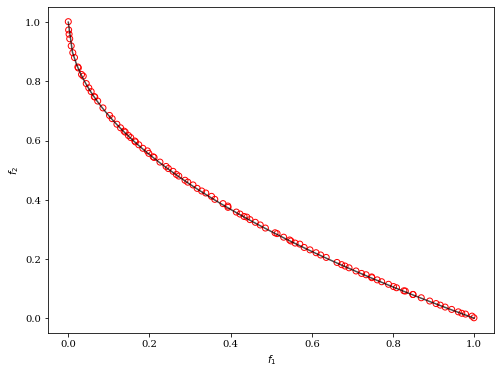

In [4]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt1")

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

In [5]:
from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-6,
    f_tol=0.0025,
    nth_gen=5,
    n_last=30,
    n_max_gen=1000,
    n_max_evals=100000
)

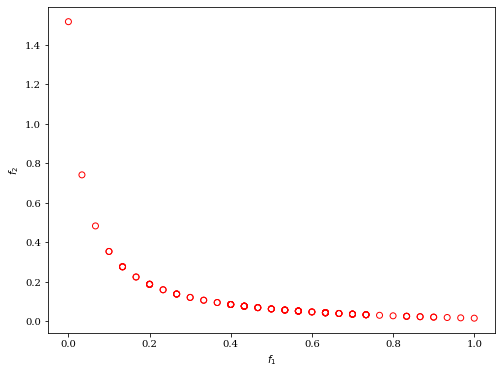

In [6]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem, get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt5")

algorithm = NSGA2(pop_size=100,
                  sampling=get_sampling("bin_random"),
                  crossover=get_crossover("bin_two_point"),
                  mutation=get_mutation("bin_bitflip"),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 500),
               seed=1,
               verbose=False)


plot = Scatter()
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

Application on the thesis project

In [7]:
# from pyomo.environ import *
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_termination
from pymoo.util import plotting
import autograd.numpy as anp
import numpy as np
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
import numpy as np
import math

# from scipy.optimize import rosen, rosen_der
# from ipopt import minimize_ipopt


# Factors for the third party in the supply chain%%
U_Demand = 12000  # normrnd(mn,std)%Monte carlo simulation mean 12000 unit%
alpha = 0.1  # Percentage of rate of return of products from third party%
lamda = alpha * U_Demand
miu = 0.1  # Probability of havieng a returned product in a good working condition%
gamma = 0.7  # Probability of having a rerurned part after disassembly with good working condition%

Q_TP = (lamda * (miu)) + (lamda * (1 - miu) * gamma)  # Quantity of the third party%

std = 200  # 10000 runslamda and %
# for daikin australia
pd_1 = 600  # round(random('Normal',600,24.49));q
pd_2 = 60  # round(random('Normal',60,7.749));
Z_var = U_Demand - pd_1 - pd_2
# Transportation Costs#
TS_s = 5000  # Transportation cost for the supplier(From alexandria road to downtown cairo)%
TS_m = 5000  # Transportation cost for the manufacturer(Assumed to be almost fixed due to practicallity)%
TS_d = 5000  # Transportation cost for the distributer%
TS_rt = 5000  # Transportation cost for the retailer%
TS_tp = 5000  # Transportation cost for the third party%
# collection Costs%%
C_tp = 5.1  # collection cost of recovering used product from the customer%
# facility opening Costs%%
F_rt = 10000000  # facility opening cost for the recovery center(Assumed to be 10 million  Egyptian pound)%
# Ordering Costs%%
S_s = 5.1
S_ms = 58.956
S_m1 = 700
S_m2 = 800
S_m3 = 850
S_d = 173.4
S_r = 204
S_tp = 42.5
# Holding Costs%%
H_s = 50.126
H_ms = 589.56
H_m = 1473.9
H_dr = 1734
H_rt = 2040
H_tp = 425.9571
# Production Rates%%
P_m1 = 200  # Production Rates assumed to be 200 unit per day for the power plant %%
P_m2 = 210
P_m3 = 220
# U_Demand = 400000 #Demand rate is asumed to be 400,000 unit per month%
P_m = P_m1 + P_m2 + P_m3  # Production rate of the manufacuter
# i_m #conunting of manufacturer%
# i_mp
# i_d   #Counting of Distributer
##Factors for the third party in the supply chain##
alpha = 0.1  # Percentage of rate of return of products from third party%
lamda = (alpha * U_Demand)
miu = 0.1  # Probability of havieng a returned product in a good working condition%
gamma = 0.7  # Probability of having a rerurned part after disassembly with good working condition%

Q_TP = (lamda * (miu)) + (lamda * (1 - miu) * gamma)  # Quantity of the third party%
# Values of supplied chain quantities
n_s = 5
n_m = 1  # 1:2
n_d = 1


class MyProblem(Problem):


    def __init__(self, n_var=12, **kwargs):
        super().__init__(n_var=n_var, n_obj=3, n_constr=15, xl=0, xu=12800000000000, type_var=anp.double, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = anp.linspace(0, 1, n_pareto_points)
        return anp.array([x, 1 - anp.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):  # Defining the Objective and constrains#
        Q_rt1 = x[0]  # quantity of the retailer in the forward cycle
        Q_rt2 = x[1]  # quantity of the retailer in the forward cycle
        Q_rt3 = x[2]  # quantity of the retailer in the forward cycle
        Q_d1 = x[3]  # Quantity of the distributer
        Q_d2 = x[4]  # Quantity of the distributer
        Q_d3 = x[5]  # Quantity of the distributer
        Q_m1 = x[6]  # Quantity of the Manufacturer
        Q_m2 = x[7]  # Quantity of the Manufacturer
        Q_m3 = x[8]  # Quantity of the Manufacturer
        Q_s1 = x[9]  # Quantity of Supplied Parts
        Q_s2 = x[10]  # Quantity of Supplied Parts
        Q_s3 = x[11]  # Quantity of Supplied Parts
        t_r = (U_Demand) / (x[0])  # Cycle time of the supply chain# #cycle time of the retailer
        t_d = n_d * t_r  # cycle time of the Distribiter
        t_m = (n_m * n_d * t_r)  # cycle time of the Manufacturer
        t_s = n_s * n_m * n_d * t_r  # cycle time of the supplier
        t_tp = t_s  # cycle time of the third party
        S_jfS = 30  # Job Index factor number of fixed jobs at the supplier assumed to be 30 fixed employees %
        S_jfM = 30  # Job index for the number of fixed jobs by Mamufacturer assumed to be 30 fixed employees %
        S_jfD = 30  # Job index for the number of fixed jobs by distributer assumed to be 30 fixed employees%
        S_jfRT = 30  # Job index for the number of fixed jobs by retialer assumed to be 30 fixed employees%
        S_jfTP = 20  # Job index for the number of fixed jobs by third party recovery assumed to be 20 fixed employees%
        S_jvS = 270  # Job Index factor number of variable jobs at the supplier assumed to be 270 workers per facility%
        S_jvM = 270  # Job index for the number of variable jobs by Mamufacturer  270 workers per facility%
        S_jvD = 270  # Job index for the number of variable jobs by distributer  270 workers per facility%
        S_jvRT = 270  # Job index for the number of variable jobs by retialer  270 workers per facility%
        S_jvTP = 100  # Job index for the number of variable jobs by third party recovery  100 workers per facility%
        S_u = 20  # Employee satisfaction factor of the refurbrished parts for the third party disassembler%
        S_rt = 30  # Customer satisfaction factor of the refurbrished parts%
        S_ds = 5  # Number of lost days at work% # Number of lost days from injuries or work damage at the suppliers / month%
        S_dm = 5  # Number of lost days from injuries or work damage at the manufactuer%
        S_dd = 5  # Number of lost days from injuries or work damage at the distributer%
        S_drt = 5  # Number of lost days from injuries or work damage at the retailer%
        S_dtp = 5  # Number of lost days from injuries or work damage at the third party%
        # Enviromental Aspect of the supply chain (Emissions calculated from carbon footprint)%
        E_q = 10  # Emission factor from production line
        E_tp = 10  # Emission from wastes removal%
        # Transportation emission cost%
        E_ts = 20  # Emission from Transportation made by the supplier%
        E_tm = 20  # Emission from Transportation made by the manufacturer%
        E_td = 20  # Emission from Transportation made by the distributer%
        E_trt = 20  # Emission from Transportation made by the retailer%
        E_ttp = 20  # Emission from Transportation made by the third party%
        i_s = 1
        i_ss = np.arange(i_s, n_s + 1, 1)
        tc_s1 = list(range(i_s, n_s + 1))
        for i_s in i_ss:
            tc_s1 = ((np.sum(i_ss) / n_s) * Q_s1 * t_s)
            i_s = i_s + 1  # Adding value of Supplier integer#
        tc_s4 = (tc_s1)

        TC_s1 = (S_s * (1 / (n_s * t_s))) + (((H_s + TS_s) / (n_s * (t_s))) * tc_s4)  # cost of the supplier for component 1%

        i_s = 1  # starting of the loop#
        i_ss = np.arange(i_s, n_s + 1, 1)
        # for w1 in w11:
        tc_s2 = list(range(i_s, n_s + 1))
        for i_s in i_ss:
            tc_s2 = ((np.sum(i_ss) / n_s) * Q_s2 * t_s)  # ((x(11)) +Q_TP#
            i_s = i_s + 1  # Adding value of Supplier integer
        tc_s5 = (tc_s2)

        TC_s2 = (S_s * (1 / (n_s * t_s))) + (((H_s + TS_s) / (n_s * (t_s))) * tc_s5)

        i_s = 1  # starting of the loop#
        tc_s3 = list(range(i_s, n_s + 1))
        for i_s in i_ss:
            tc_s3 = ((np.sum(i_ss) / n_s) * Q_s3 * t_s)  # ((x(12)+ Q_TP))%
            i_s = i_s + 1  # Adding value of Supplier integer (No addition for Q_TP )%
        tc_s6 = tc_s3
        TC_s3 = (S_s * (1 / (n_s * t_s))) + (
                    ((H_s + TS_s) / (n_s * (t_s))) * tc_s6)  # cost of the supplier for component 3%
        i_m = 1  # starting of the loop#
        i_mm = np.arange(i_m, n_m + 1, 1)
        # for w1 in w11:
        tc_m2 = list(range(i_m, n_m + 1))
        for i_m in i_mm:
            tc_m1 = np.arange(1, n_m, 1)  # Defining range with starting and ending point
            tc_m2 = np.sum((1 - ((i_mm) / (n_m))) * ((Q_m1) + Q_TP))  # Defining range with start & ending point#
            i_m = i_m + 1  # Adding value of manufacturer integer#
        tc_m3 = (tc_m2)
        tc_s7 = np.arange(1, n_s, 1)
        # Total cost of manufacturer#
        tc_m = sum(tc_m1)
        tc_s8 = sum(tc_s7)
        TC_m = (H_m * ((0.5 * (Q_m1 ** 2) * (1 / P_m1)) \
                       + (tc_m * (Q_m1 * t_m * (1 / (n_m ** 2)))))) \
               + ((S_m1 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
               + (H_ms * (1 / t_s) * (((((Q_s1 + Q_TP) * Q_m1) / P_m1)) \
                                      + (tc_s8 * (((Q_s1) + Q_TP) / n_s) * (t_m - (Q_m1 / P_m1)))))

        TC_m2 = (H_m * ((0.5 * (Q_m2 ** 2) * (1 / P_m2)) \
                        + (tc_m * (Q_m2 * t_m * (1 / (n_m ** 2)))))) \
                + ((S_m2 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                + (H_ms * (1 / t_s) * (((((Q_s2 + Q_TP) * Q_m2) / P_m2)) \
                                       + (tc_s8 * (((Q_s2) + Q_TP) / n_s) * (t_m - (Q_m2 / P_m2)))))
        TC_m3 = (H_m * ((0.5 * (Q_m3 ** 2) * (1 / P_m3)) \
                        + (tc_m * (Q_m3 * t_m * (1 / (n_m ** 2)))))) \
                + ((S_m3 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                + (H_ms * (1 / t_s) * (((((Q_s3 + Q_TP) * Q_m3) / P_m3)) \
                                       + (tc_s8 * (((Q_s3) + Q_TP) / n_s) * (t_m - (Q_m3 / P_m3)))))

        i_d = 1
        i_dd = np.arange(i_d, n_d + 1, 1)
        # for w1 in w11:
        tc_d1 = list(range(i_d, n_d + 1))
        tc_d2 = list(range(i_d, n_d + 1))
        tc_d3 = list(range(i_d, n_d + 1))
        for i_d in i_dd:
            tc_d1 = np.sum(((i_dd) / (n_d)) * (Q_d1))  # Cost of the Distributer for Product 1%%
            tc_d2 = np.sum(((i_dd) / (n_d)) * (Q_d2))  # Cost of the Distributer for Product 2%%
            tc_d3 = np.sum(((i_d) / (n_d)) * (Q_d3))  # Cost of the Distributer for Product 3%%
            i_d = i_d + 1

        tc_d_f = (tc_d1) + (tc_d2) + (tc_d3)
        TC_d = (H_dr * (tc_d_f / n_d)) + (
                    (S_d + TS_d) * (1 / t_d))  # Total cost of the distributer of the supply chain%
        # Total cost of retailer

        TC_rt = (H_rt * ((Q_rt1) / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer%%
        TC_rt2 = (H_rt * (Q_rt2 / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer for product 2%%
        TC_rt3 = (H_rt * ((Q_rt3) / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer for product 3%%
        # Total cost of third party recovery
        TC_tp = ((H_tp / 2) * Q_TP) + ((S_tp + TS_tp) * (1 / t_tp))
        S_jfS = 30  # Job Index factor number of fixed jobs at the supplier assumed to be 30 fixed employees %
        S_jfM = 30  # Job index for the number of fixed jobs by Mamufacturer assumed to be 30 fixed employees %
        S_jfD = 30  # Job index for the number of fixed jobs by distributer assumed to be 30 fixed employees%
        S_jfRT = 30  # Job index for the number of fixed jobs by retialer assumed to be 30 fixed employees%
        S_jfTP = 20  # Job index for the number of fixed jobs by third party recovery assumed to be 20 fixed employees%
        S_jvS = 270  # Job Index factor number of variable jobs at the supplier assumed to be 270 workers per facility%
        S_jvM = 270  # Job index for the number of variable jobs by Mamufacturer  270 workers per facility%
        S_jvD = 270  # Job index for the number of variable jobs by distributer  270 workers per facility%
        S_jvRT = 270  # Job index for the number of variable jobs by retialer  270 workers per facility%
        S_jvTP = 100  # Job index for the number of variable jobs by third party recovery  100 workers per facility%
        S_u = 20  # Employee satisfaction factor of the refurbrished parts for the third party disassembler%
        S_rt = 30  # Customer satisfaction factor of the refurbrished parts%
        # Number of lost days at work%
        S_ds = 5  # Number of lost days from injuries or work damage at the suppliers / month%
        S_dm = 5  # Number of lost days from injuries or work damage at the manufactuer%
        S_dd = 5  # Number of lost days from injuries or work damage at the distributer%
        S_drt = 5  # Number of lost days from injuries or work damage at the retailer%
        S_dtp = 5  # Number of lost days from injuries or work damage at the third party%
        # Enviromental Aspect of the supply chain (Emissions calculated from carbon footprint)%
        E_q = 10  # Emission factor from production line
        E_tp = 10  # Emission from wastes removal%
        # Transportation emission cost%
        E_ts = 20  # Emission from Transportation made by the supplier%
        E_tm = 20  # Emission from Transportation made by the manufacturer%
        E_td = 20  # Emission from Transportation made by the distributer%
        E_trt = 20  # Emission from Transportation made by the retailer%
        E_ttp = 20  # Emission from Transportation made by the third party%
        # Cycle time%

        EQO = TC_s1 + TC_s2 + TC_s3 + TC_m + TC_m2 + TC_m3 + TC_d + TC_rt \
              + TC_rt2 + TC_rt3 + TC_tp
        #       Economical aspect#
        LSC = (S_jfS + S_jfM + S_jfD + S_jfRT + S_jfTP) \
              + ((S_jvS * Q_s1) + (S_jvD * Q_d1) + (S_jvM * Q_m1) \
                 + (S_jvRT * Q_rt1) + (S_jvTP * Q_TP)) \
              + (S_u * (U_Demand))  + (S_rt * Q_rt1) - (S_ds * Q_s1) \
              - (S_dd * Q_d1) - (S_dm * Q_m1) - (S_drt * Q_rt1) \
              - (S_dtp * Q_TP)  # Social aspect equation%

        ESC = (E_q * (Q_s1 + Q_d1 + Q_m1 + Q_rt1)) \
              + (E_ts * (1 / t_s)) + (E_td * (1 / t_d)) \
              + (E_tm * (1 / t_m)) + (E_trt * (1 / t_r)) \
              + (E_ts * (1 / t_tp)) + (E_tp * Q_TP)  # Enviromental aspect

        w1 = 1
        w2 = 1
        w3 = 1
        f1 = EQO * w1
        f2 = -LSC * w2
        f3 = ESC * w3

        g1 =  U_Demand -x[0]
        g2 =  U_Demand -x[1]
        g3 =  U_Demand -x[2]
        g4 = -((x[9]) + Q_TP) + (n_s * x[6])
        g5 = -((x[10]) + Q_TP) + (n_s * x[7])
        g6 = -((x[11]) + Q_TP) + (n_s * x[8])
        g7 = (n_m * (x[3])) - x[6]
        g8 = (n_m * (x[4])) - x[7]
        g9 = (n_m * (x[5])) - x[8]
        g10 =  (n_d * x[0]) -x[3]
        g11 = (n_d * x[1]) -x[4] 
        g12 = (n_d * x[2]) -x[5] 
        g13 = x[0]
        g14 = x[1]
        g15 = x[2]
        out["F"] = anp.column_stack([f1, f2, f3])
        out["G"] = anp.column_stack([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, \
                                     g13, g14, g15])


problem = MyProblem()
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(pop_size=600,ref_dirs=ref_dirs)

from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-6,
    f_tol=0.01,
    nth_gen=600,
    n_last=700,
    n_max_gen=600,
    n_max_evals=100000
)
# execute the optimization
res = minimize(problem,
               algorithm,
               seed=1,
               termination=('n_gen', 600))

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)
plot = Scatter()
plot.add(res.F, color="red")
plot.show()


Exception: ignored

In [35]:
import matplotlib.pyplot as plt

Import library and define parameters

In [ ]:
# from pyomo.environ import *
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_termination
from pymoo.util import plotting
import autograd.numpy as anp
import numpy as np
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
import numpy as np
import math
p=0
mu, sigma = 12000, 1000 #mean and standard deviation
de1 = np.random.default_rng().normal(mu, sigma, 10)
de=np.arange(p,10,1)
mu, sigma = 12000, 1000 #mean and standard deviation
dmns = np.random.default_rng().normal(mu, sigma, 10)
#dmns = np.arange(0,5000,500)
demns=np.arange(0,10,1)
ecco=np.arange(0,10,1)
envo=np.arange(0,10,1)
soco=np.arange(0,10,1)
ret=np.arange(0,10,1)
qrt1=np.arange(0,10,1)
qrt1[0]==0
import pandas as pd
ecco = ecco.astype(float)
envo = envo.astype(float)
soco = soco.astype(float)
qrt1 = qrt1.astype(float)

for p in de:
    #Factors for the third party in the supply chain%%
    taw=qrt1[p]-dmns[p]
    if  taw > 0:
      U_Demand =  taw #normrnd(mn,std)%Monte carlo simulation mean 12000 unit%
    else :
      U_Demand = dmns[p]- qrt1[p]
    alpha = 0.1  # Percentage of rate of return of products from third party%
    lamda = alpha * U_Demand
    miu = 0.1  # Probability of havieng a returned product in a good working condition%
    gamma = 0.7  # Probability of having a rerurned part after disassembly with good working condition%
    tu, alfa = 900, 100 #mean and standard deviation
    Q_TP = np.random.normal(tu, alfa, 1)#Quantity of the third party%
    #Q_TP=rats[p]
    #Q_TP = (lamda * (miu)) + (lamda * (1 - miu) * gamma)  # Quantity of the third party%

    std = 200  # 10000 runslamda and %
    # for daikin australia
    pd_1 = 600  # round(random('Normal',600,24.49));q
    pd_2 = 60  # round(random('Normal',60,7.749));
    Z_var = U_Demand - pd_1 - pd_2
    # Transportation Costs#
    TS_s = 5000  # Transportation cost for the supplier(From alexandria road to downtown cairo)%
    TS_m = 5000  # Transportation cost for the manufacturer(Assumed to be almost fixed due to practicallity)%
    TS_d = 5000  # Transportation cost for the distributer%
    TS_rt = 5000  # Transportation cost for the retailer%
    TS_tp = 5000  # Transportation cost for the third party%
    # collection Costs%%
    C_tp = 5.1  # collection cost of recovering used product from the customer%
    # facility opening Costs%%
    F_rt = 10000000  # facility opening cost for the recovery center(Assumed to be 10 million  Egyptian pound)%
    # Ordering Costs%%
    S_s = 5.1
    S_ms = 58.956
    S_m1 = 700
    S_m2 = 800
    S_m3 = 850
    S_d = 173.4
    S_r = 204
    S_tp = 42.5
    # Holding Costs%%
    H_s = 50.126
    H_ms = 589.56
    H_m = 1473.9
    H_dr = 1734
    H_rt = 2040
    H_tp = 425.9571
    # Production Rates%%
    P_m1 = 200  # Production Rates assumed to be 200 unit per day for the power plant %%
    P_m2 = 210
    P_m3 = 220
    # U_Demand = 400000 #Demand rate is asumed to be 400,000 unit per month%
    P_m = P_m1 + P_m2 + P_m3  # Production rate of the manufacuter
    # i_m #conunting of manufacturer%
    # i_mp
    # i_d   #Counting of Distributer
    ##Factors for the third party in the supply chain##
    alpha = 0.1  # Percentage of rate of return of products from third party%
    lamda = (alpha * U_Demand)
    miu = 0.1  # Probability of havieng a returned product in a good working condition%
    gamma = 0.7  # Probability of having a rerurned part after disassembly with good working condition%

    #Q_TP = (lamda * (miu)) + (lamda * (1 - miu) * gamma)  # Quantity of the third party%
    # Values of supplied chain quantities
    n_s = 1
    n_m = 1  # 1:2
    n_d = 1
    from pymoo.core.problem import ElementwiseProblem
    from pymoo.core.problem import ElementwiseProblem
    class MyProblem(ElementwiseProblem):


        def __init__(self, n_var=12, **kwargs):
            super().__init__(n_var=n_var, n_obj=3, n_constr=16, xl=1000, xu=50000000, type_var=anp.double, **kwargs)

        def _calc_pareto_front(self, n_pareto_points=100):
            x = anp.linspace(0, 1, n_pareto_points)
            return anp.array([x, 1 - anp.sqrt(x)]).T

        def _evaluate(self, x, out, *args, **kwargs):  # Defining the Objective and constrains#
            Q_rt1 = x[0]  # quantity of the retailer in the forward cycle
            Q_rt2 = x[1]  # quantity of the retailer in the forward cycle
            Q_rt3 = x[2]  # quantity of the retailer in the forward cycle
            Q_d1 = x[3]  # Quantity of the distributer
            Q_d2 = x[4]  # Quantity of the distributer
            Q_d3 = x[5]  # Quantity of the distributer
            Q_m1 = x[6]  # Quantity of the Manufacturer
            Q_m2 = x[7]  # Quantity of the Manufacturer
            Q_m3 = x[8]  # Quantity of the Manufacturer
            Q_s1 = x[9]  # Quantity of Supplied Parts
            Q_s2 = x[10]  # Quantity of Supplied Parts
            Q_s3 = x[11]  # Quantity of Supplied Parts
            t_r = (U_Demand) / (x[0])  # Cycle time of the supply chain# #cycle time of the retailer
            t_d = n_d * t_r  # cycle time of the Distribiter
            t_m = (n_m * n_d * t_r)  # cycle time of the Manufacturer
            t_s = n_s * n_m * n_d * t_r  # cycle time of the supplier
            t_tp = t_s  # cycle time of the third party
            S_jfS = 30  # Job Index factor number of fixed jobs at the supplier assumed to be 30 fixed employees %
            S_jfM = 30  # Job index for the number of fixed jobs by Mamufacturer assumed to be 30 fixed employees %
            S_jfD = 30  # Job index for the number of fixed jobs by distributer assumed to be 30 fixed employees%
            S_jfRT = 30  # Job index for the number of fixed jobs by retialer assumed to be 30 fixed employees%
            S_jfTP = 20  # Job index for the number of fixed jobs by third party recovery assumed to be 20 fixed employees%
            S_jvS = 270  # Job Index factor number of variable jobs at the supplier assumed to be 270 workers per facility%
            S_jvM = 270  # Job index for the number of variable jobs by Mamufacturer  270 workers per facility%
            S_jvD = 270  # Job index for the number of variable jobs by distributer  270 workers per facility%
            S_jvRT = 270  # Job index for the number of variable jobs by retialer  270 workers per facility%
            S_jvTP = 100  # Job index for the number of variable jobs by third party recovery  100 workers per facility%
            S_u = 20  # Employee satisfaction factor of the refurbrished parts for the third party disassembler%
            S_rt = 30  # Customer satisfaction factor of the refurbrished parts%
            S_ds = 5  # Number of lost days at work% # Number of lost days from injuries or work damage at the suppliers / month%
            S_dm = 5  # Number of lost days from injuries or work damage at the manufactuer%
            S_dd = 5  # Number of lost days from injuries or work damage at the distributer%
            S_drt = 5  # Number of lost days from injuries or work damage at the retailer%
            S_dtp = 5  # Number of lost days from injuries or work damage at the third party%
            # Enviromental Aspect of the supply chain (Emissions calculated from carbon footprint)%
            E_q = 10  # Emission factor from production line
            E_tp = 10  # Emission from wastes removal%
            # Transportation emission cost%
            E_ts = 20  # Emission from Transportation made by the supplier%
            E_tm = 20  # Emission from Transportation made by the manufacturer%
            E_td = 20  # Emission from Transportation made by the distributer%
            E_trt = 20  # Emission from Transportation made by the retailer%
            E_ttp = 20  # Emission from Transportation made by the third party%
            i_s = 1
            i_ss = np.arange(i_s, n_s + 1, 1)
            tc_s1 = list(range(i_s, n_s + 1))
            for i_s in i_ss:
                tc_s1 = ((np.sum(i_ss) / n_s) * Q_s1 * t_s)
                i_s = i_s + 1  # Adding value of Supplier integer#
            tc_s4 = (tc_s1)

            TC_s1 = (S_s * (1 / (n_s * t_s))) + (((H_s + TS_s) / (n_s * (t_s))) * tc_s4)  # cost of the supplier for component 1%

            i_s = 1  # starting of the loop#
            i_ss = np.arange(i_s, n_s + 1, 1)
            # for w1 in w11:
            tc_s2 = list(range(i_s, n_s + 1))
            for i_s in i_ss:
                tc_s2 = ((np.sum(i_ss) / n_s) * Q_s2 * t_s)  # ((x(11)) +Q_TP#
                i_s = i_s + 1  # Adding value of Supplier integer
            tc_s5 = (tc_s2)

            TC_s2 = (S_s * (1 / (n_s * t_s))) + (((H_s + TS_s) / (n_s * (t_s))) * tc_s5)

            i_s = 1  # starting of the loop#
            tc_s3 = list(range(i_s, n_s + 1))
            for i_s in i_ss:
                tc_s3 = ((np.sum(i_ss) / n_s) * Q_s3 * t_s)  # ((x(12)+ Q_TP))%
                i_s = i_s + 1  # Adding value of Supplier integer (No addition for Q_TP )%
            tc_s6 = tc_s3
            TC_s3 = (S_s * (1 / (n_s * t_s))) + (
                        ((H_s + TS_s) / (n_s * (t_s))) * tc_s6)  # cost of the supplier for component 3%
            i_m = 1  # starting of the loop#
            i_mm = np.arange(i_m, n_m + 1, 1)
            # for w1 in w11:
            tc_m2 = list(range(i_m, n_m + 1))
            for i_m in i_mm:
                tc_m1 = np.arange(1, n_m, 1)  # Defining range with starting and ending point
                tc_m2 = np.sum((1 - ((i_mm) / (n_m))) * ((Q_m1) + Q_TP))  # Defining range with start & ending point#
                i_m = i_m + 1  # Adding value of manufacturer integer#
            tc_m3 = (tc_m2)
            tc_s7 = np.arange(1, n_s, 1)
            # Total cost of manufacturer#
            tc_m = sum(tc_m1)
            tc_s8 = sum(tc_s7)
            TC_m = (H_m * ((0.5 * (Q_m1 ** 2) * (1 / P_m1)) \
                          + (tc_m * (Q_m1 * t_m * (1 / (n_m ** 2)))))) \
                  + ((S_m1 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                  + (H_ms * (1 / t_s) * (((((Q_s1 + Q_TP) * Q_m1) / P_m1)) \
                                          + (tc_s8 * (((Q_s1) + Q_TP) / n_s) * (t_m - (Q_m1 / P_m1)))))

            TC_m2 = (H_m * ((0.5 * (Q_m2 ** 2) * (1 / P_m2)) \
                            + (tc_m * (Q_m2 * t_m * (1 / (n_m ** 2)))))) \
                    + ((S_m2 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                    + (H_ms * (1 / t_s) * (((((Q_s2 + Q_TP) * Q_m2) / P_m2)) \
                                          + (tc_s8 * (((Q_s2) + Q_TP) / n_s) * (t_m - (Q_m2 / P_m2)))))
            TC_m3 = (H_m * ((0.5 * (Q_m3 ** 2) * (1 / P_m3)) \
                            + (tc_m * (Q_m3 * t_m * (1 / (n_m ** 2)))))) \
                    + ((S_m3 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                    + (H_ms * (1 / t_s) * (((((Q_s3 + Q_TP) * Q_m3) / P_m3)) \
                                          + (tc_s8 * (((Q_s3) + Q_TP) / n_s) * (t_m - (Q_m3 / P_m3)))))

            i_d = 1
            i_dd = np.arange(i_d, n_d + 1, 1)
            # for w1 in w11:
            tc_d1 = list(range(i_d, n_d + 1))
            tc_d2 = list(range(i_d, n_d + 1))
            tc_d3 = list(range(i_d, n_d + 1))
            for i_d in i_dd:
                tc_d1 = np.sum(((i_dd) / (n_d)) * (Q_d1))  # Cost of the Distributer for Product 1%%
                tc_d2 = np.sum(((i_dd) / (n_d)) * (Q_d2))  # Cost of the Distributer for Product 2%%
                tc_d3 = np.sum(((i_d) / (n_d)) * (Q_d3))  # Cost of the Distributer for Product 3%%
                i_d = i_d + 1

            tc_d_f = (tc_d1) + (tc_d2) + (tc_d3)
            TC_d = (H_dr * (tc_d_f / n_d)) + (
                        (S_d + TS_d) * (1 / t_d))  # Total cost of the distributer of the supply chain%
            # Total cost of retailer

            TC_rt = (H_rt * ((Q_rt1) / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer%%
            TC_rt2 = (H_rt * (Q_rt2 / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer for product 2%%
            TC_rt3 = (H_rt * ((Q_rt3) / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer for product 3%%
            # Total cost of third party recovery
            TC_tp = ((H_tp / 2) * Q_TP) + ((S_tp + TS_tp) * (1 / t_tp))
            S_jfS = 30  # Job Index factor number of fixed jobs at the supplier assumed to be 30 fixed employees %
            S_jfM = 30  # Job index for the number of fixed jobs by Mamufacturer assumed to be 30 fixed employees %
            S_jfD = 30  # Job index for the number of fixed jobs by distributer assumed to be 30 fixed employees%
            S_jfRT = 30  # Job index for the number of fixed jobs by retialer assumed to be 30 fixed employees%
            S_jfTP = 20  # Job index for the number of fixed jobs by third party recovery assumed to be 20 fixed employees%
            S_jvS = 270  # Job Index factor number of variable jobs at the supplier assumed to be 270 workers per facility%
            S_jvM = 270  # Job index for the number of variable jobs by Mamufacturer  270 workers per facility%
            S_jvD = 270  # Job index for the number of variable jobs by distributer  270 workers per facility%
            S_jvRT = 270  # Job index for the number of variable jobs by retialer  270 workers per facility%
            S_jvTP = 100  # Job index for the number of variable jobs by third party recovery  100 workers per facility%
            S_u = 20  # Employee satisfaction factor of the refurbrished parts for the third party disassembler%
            S_rt = 30  # Customer satisfaction factor of the refurbrished parts%
            # Number of lost days at work%
            S_ds = 5  # Number of lost days from injuries or work damage at the suppliers / month%
            S_dm = 5  # Number of lost days from injuries or work damage at the manufactuer%
            S_dd = 5  # Number of lost days from injuries or work damage at the distributer%
            S_drt = 5  # Number of lost days from injuries or work damage at the retailer%
            S_dtp = 5  # Number of lost days from injuries or work damage at the third party%
            # Enviromental Aspect of the supply chain (Emissions calculated from carbon footprint)%
            E_q = 10  # Emission factor from production line
            E_tp = 10  # Emission from wastes removal%
            # Transportation emission cost%
            E_ts = 20  # Emission from Transportation made by the supplier%
            E_tm = 20  # Emission from Transportation made by the manufacturer%
            E_td = 20  # Emission from Transportation made by the distributer%
            E_trt = 20  # Emission from Transportation made by the retailer%
            E_ttp = 20  # Emission from Transportation made by the third party%
            # Cycle time%

            EQO = TC_s1 + TC_s2 + TC_s3 + TC_m + TC_m2 + TC_m3 + TC_d + TC_rt \
                  + TC_rt2 + TC_rt3 + TC_tp
            #       Economical aspect#
            LSC = (S_jfS + S_jfM + S_jfD + S_jfRT + S_jfTP) \
                  + ((S_jvS * Q_s1) + (S_jvD * Q_d1) + (S_jvM * Q_m1) \
                    + (S_jvRT * Q_rt1) + (S_jvTP * Q_TP)) \
                  + (S_u * (U_Demand))  + (S_rt * Q_rt1) - (S_ds * Q_s1) \
                  - (S_dd * Q_d1) - (S_dm * Q_m1) - (S_drt * Q_rt1) \
                  - (S_dtp * Q_TP)  # Social aspect equation%

            ESC = (E_q * (Q_s1 + Q_d1 + Q_m1 + Q_rt1)) \
                  + (E_ts * (1 / t_s)) + (E_td * (1 / t_d)) \
                  + (E_tm * (1 / t_m)) + (E_trt * (1 / t_r)) \
                  + (E_ts * (1 / t_tp)) + (E_tp * Q_TP)  # Enviromental aspect

            w1 = 1
            w2 = 1
            w3 = 1
            f1 = EQO * w1
            f2 = LSC * w2
            f3 = ESC * w3

            g1 = -x[0] + U_Demand
            g2 = -x[1] + U_Demand
            g3 = -x[2] + U_Demand
            g4 = -f1+f2-f3
            g5 = -((x[9]) + Q_TP) + (n_s * x[6])
            g6 = -((x[10]) + Q_TP) + (n_s * x[7])
            g7 = -((x[11]) + Q_TP) + (n_s * x[8])
            g8 = (n_m * (x[3])) - x[6]
            g9 = (n_m * (x[4])) - x[7]
            g10 = (n_m * (x[5])) - x[8]
            g11 = -x[3] + (n_d * x[0])
            g12 = -x[4] + (n_d * x[1])
            g13 = -x[5] + (n_d * x[2])
            g14 = -x[0]
            g15 = -x[1]
            g16 = -x[2]

            out["F"] = anp.column_stack([f1, -f2, f3])
            out["G"] = anp.column_stack([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, \
                                        g13, g14, g15, g16])
    elementwise_problem = MyProblem()
    elementwise_problem = MyProblem()
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

    # create the algorithm object
    algorithm = NSGA3(pop_size=200,ref_dirs=ref_dirs,eliminate_duplicates=True)

    from pymoo.util.termination.default import MultiObjectiveDefaultTermination

    termination = MultiObjectiveDefaultTermination(
        x_tol=1e-8,
        cv_tol=1e-6,
        f_tol=0.001,
        nth_gen=5,
        n_last=30,
        n_max_gen=1000,
        n_max_evals=100000
    )
    # execute the optimization
    res = minimize(elementwise_problem,
                  algorithm,
                  seed=1,
                  termination=('n_gen', 2000))
    print("Best solution found: %s" % res.X)
    print("Function value: %s" % res.F)
    print("Constraint violation: %s" % res.CV)
    Scatter().add(res.F).show()
    plot = Scatter()
    plot.add(res.F, color="red")
    plot.show()
    eco_obj = eco_obj.astype(float)
    envo_obj = envo_obj.astype(float)
    soc_obj = soc_obj.astype(float)
    eco_obj=res.F[0,0]
    ecco[p]= float(res.F[0,0])
    envo_obj=-res.F[0,1]
    envo[p]= -float(res.F[0,1])
    soc_obj=res.F[0,2]
    soco[p]= float(res.F[0,2])
    ret[p]=Q_TP
    qrt1[p]=res.X[0,0]
    demns[p]=qrt1[p]-dmns[p]
    

    print('The economic optimal value is',eco_obj)
    print('The enivronmental optimal value is',envo_obj)
    print('The social optimal value is',soc_obj)
    print('The {} th part is completed'.format(p))
    p=p+1


plt.plot(dmns,ecco,label='Economic objective vs Demand')
plt.xlabel('Demand')
plt.ylabel('Economic objective function')
plt.title('Economic objective vs demand')
plt.show()
plt.plot(dmns,envo,label='Environmental objective vs demand')
plt.xlabel('Demand')
plt.ylabel('Environmental objective function')
plt.title('Environmental objective vs demand')
plt.show()
plt.plot(dmns,soco,label='Social objective vs demand')
plt.xlabel('Demand')
plt.ylabel('Social objective function')
plt.title('Social objective vs demand')
plt.show()
plt.plot(ret,soco,label='Social objective vs rate of return')
plt.xlabel('Rate of return')
plt.ylabel('Social objective function')
plt.title('Social objective vs rate of return')
plt.show()
plt.plot(ret,ecco,label='Economic objective vs  rate of return')
plt.xlabel(' Rate of return')
plt.ylabel('Economic objective function')
plt.title('Economic objective vs  rate of return')
plt.show()
plt.plot(ret,envo,label='Environmental objective vs  rate of return')
plt.xlabel(' Rate of return')
plt.ylabel('Environmental objective function')
plt.title('Environmental objective vs  rate of return')
plt.show()


Best solution found: [[1.48641820e+04 2.08557813e+05 5.18366941e+05 2.28635990e+04
  1.10325544e+07 1.96347034e+07 3.62550149e+04 1.51747080e+07
  2.55050307e+07 5.86708992e+04 4.77120613e+07 4.80070284e+07]
 [4.84211085e+06 2.04634945e+06 7.91581712e+06 4.85157841e+06
  8.27983986e+06 1.27225659e+07 4.86034940e+06 4.65662024e+07
  4.84207308e+07 5.08244169e+06 4.99764090e+07 4.96330976e+07]
 [6.58777017e+06 1.08841835e+06 7.60909678e+05 7.77029889e+06
  1.21470868e+07 1.65788101e+07 9.24508141e+06 4.65809682e+07
  4.02475883e+07 4.96540125e+07 4.99085869e+07 4.96639853e+07]
 [2.35890871e+04 8.68474310e+05 7.47524292e+06 2.61587136e+07
  9.13939906e+06 8.12401439e+06 4.29987043e+07 4.43455568e+07
  4.07009663e+07 4.91531713e+07 4.99786998e+07 4.97443003e+07]
 [8.88643374e+05 1.70538404e+06 1.95123375e+06 4.99863621e+07
  8.40667007e+06 1.45870371e+07 4.99902719e+07 9.08793651e+06
  2.09214622e+07 4.99997909e+07 2.13570346e+07 2.63079966e+07]
 [1.97217319e+07 7.59879011e+05 1.31141141e+

In [24]:
mu, sigma = 12000, 1000 # mean and standard deviation
U_Demand = np.random.normal(mu, sigma, 1)

In [25]:
# from pyomo.environ import *
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_termination
from pymoo.util import plotting
import autograd.numpy as anp
import numpy as np
from pymoo.util.misc import stack
from pymoo.core.problem import Problem
import numpy as np
import math

# from scipy.optimize import rosen, rosen_der
# from ipopt import minimize_ipopt


# Factors for the third party in the supply chain%%
mu, sigma = 12000, 1000 # mean and standard deviation
U_Demand = 677.66862535
#U_Demand = 12000  # normrnd(mn,std)%Monte carlo simulation mean 12000 unit%
alpha = 0.1  # Percentage of rate of return of products from third party%
lamda = alpha * U_Demand
miu = 0.1  # Probability of havieng a returned product in a good working condition%
gamma = 0.7  # Probability of having a rerurned part after disassembly with good working condition%
tu, alfa = 900, 100 #mean and standard deviation
Q_TP = np.random.normal(tu, alfa, 1)#Quantity of the third party%
#Q_TP=rats[p]
#Q_TP = (lamda * (miu)) + (lamda * (1 - miu) * gamma)  # Quantity of the third party%

std = 200  # 10000 runslamda and %
# for daikin australia
pd_1 = 600  # round(random('Normal',600,24.49));q
pd_2 = 60  # round(random('Normal',60,7.749));
Z_var = U_Demand - pd_1 - pd_2
# Transportation Costs#
TS_s = 5000  # Transportation cost for the supplier(From alexandria road to downtown cairo)%
TS_m = 5000  # Transportation cost for the manufacturer(Assumed to be almost fixed due to practicallity)%
TS_d = 5000  # Transportation cost for the distributer%
TS_rt = 5000  # Transportation cost for the retailer%
TS_tp = 5000  # Transportation cost for the third party%
# collection Costs%%
C_tp = 5.1  # collection cost of recovering used product from the customer%
# facility opening Costs%%
F_rt = 10000000  # facility opening cost for the recovery center(Assumed to be 10 million  Egyptian pound)%
# Ordering Costs%%
S_s = 5.1
S_ms = 58.956
S_m1 = 700
S_m2 = 800
S_m3 = 850
S_d = 173.4
S_r = 204
S_tp = 42.5
# Holding Costs%%
H_s = 50.126
H_ms = 589.56
H_m = 1473.9
H_dr = 1734
H_rt = 2040
H_tp = 425.9571
# Production Rates%%
P_m1 = 200  # Production Rates assumed to be 200 unit per day for the power plant %%
P_m2 = 210
P_m3 = 220
# U_Demand = 400000 #Demand rate is asumed to be 400,000 unit per month%
P_m = P_m1 + P_m2 + P_m3  # Production rate of the manufacuter
# i_m #conunting of manufacturer%
# i_mp
# i_d   #Counting of Distributer
##Factors for the third party in the supply chain##
alpha = 0.1  # Percentage of rate of return of products from third party%
lamda = (alpha * U_Demand)
miu = 0.1  # Probability of havieng a returned product in a good working condition%
gamma = 0.7  # Probability of having a rerurned part after disassembly with good working condition%

#Q_TP = (lamda * (miu)) + (lamda * (1 - miu) * gamma)  # Quantity of the third party%
# Values of supplied chain quantities
n_s = 1
n_m = 1  # 1:2
n_d = 1
from pymoo.core.problem import ElementwiseProblem



Stochastic value gathering for U demand and Q tp

In [26]:
U_Demand

677.66862535

In [27]:
Q_TP

array([979.61994303])

Define problem 

In [28]:
from pymoo.core.problem import ElementwiseProblem
class MyProblem(ElementwiseProblem):


    def __init__(self, n_var=12, **kwargs):
        super().__init__(n_var=n_var, n_obj=3, n_constr=16, xl=1000, xu=50000000, type_var=anp.double, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = anp.linspace(0, 1, n_pareto_points)
        return anp.array([x, 1 - anp.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):  # Defining the Objective and constrains#
        Q_rt1 = x[0]  # quantity of the retailer in the forward cycle
        Q_rt2 = x[1]  # quantity of the retailer in the forward cycle
        Q_rt3 = x[2]  # quantity of the retailer in the forward cycle
        Q_d1 = x[3]  # Quantity of the distributer
        Q_d2 = x[4]  # Quantity of the distributer
        Q_d3 = x[5]  # Quantity of the distributer
        Q_m1 = x[6]  # Quantity of the Manufacturer
        Q_m2 = x[7]  # Quantity of the Manufacturer
        Q_m3 = x[8]  # Quantity of the Manufacturer
        Q_s1 = x[9]  # Quantity of Supplied Parts
        Q_s2 = x[10]  # Quantity of Supplied Parts
        Q_s3 = x[11]  # Quantity of Supplied Parts
        t_r = (U_Demand) / (x[0])  # Cycle time of the supply chain# #cycle time of the retailer
        t_d = n_d * t_r  # cycle time of the Distribiter
        t_m = (n_m * n_d * t_r)  # cycle time of the Manufacturer
        t_s = n_s * n_m * n_d * t_r  # cycle time of the supplier
        t_tp = t_s  # cycle time of the third party
        S_jfS = 30  # Job Index factor number of fixed jobs at the supplier assumed to be 30 fixed employees %
        S_jfM = 30  # Job index for the number of fixed jobs by Mamufacturer assumed to be 30 fixed employees %
        S_jfD = 30  # Job index for the number of fixed jobs by distributer assumed to be 30 fixed employees%
        S_jfRT = 30  # Job index for the number of fixed jobs by retialer assumed to be 30 fixed employees%
        S_jfTP = 20  # Job index for the number of fixed jobs by third party recovery assumed to be 20 fixed employees%
        S_jvS = 270  # Job Index factor number of variable jobs at the supplier assumed to be 270 workers per facility%
        S_jvM = 270  # Job index for the number of variable jobs by Mamufacturer  270 workers per facility%
        S_jvD = 270  # Job index for the number of variable jobs by distributer  270 workers per facility%
        S_jvRT = 270  # Job index for the number of variable jobs by retialer  270 workers per facility%
        S_jvTP = 100  # Job index for the number of variable jobs by third party recovery  100 workers per facility%
        S_u = 20  # Employee satisfaction factor of the refurbrished parts for the third party disassembler%
        S_rt = 30  # Customer satisfaction factor of the refurbrished parts%
        S_ds = 5  # Number of lost days at work% # Number of lost days from injuries or work damage at the suppliers / month%
        S_dm = 5  # Number of lost days from injuries or work damage at the manufactuer%
        S_dd = 5  # Number of lost days from injuries or work damage at the distributer%
        S_drt = 5  # Number of lost days from injuries or work damage at the retailer%
        S_dtp = 5  # Number of lost days from injuries or work damage at the third party%
        # Enviromental Aspect of the supply chain (Emissions calculated from carbon footprint)%
        E_q = 10  # Emission factor from production line
        E_tp = 10  # Emission from wastes removal%
        # Transportation emission cost%
        E_ts = 20  # Emission from Transportation made by the supplier%
        E_tm = 20  # Emission from Transportation made by the manufacturer%
        E_td = 20  # Emission from Transportation made by the distributer%
        E_trt = 20  # Emission from Transportation made by the retailer%
        E_ttp = 20  # Emission from Transportation made by the third party%
        i_s = 1
        i_ss = np.arange(i_s, n_s + 1, 1)
        tc_s1 = list(range(i_s, n_s + 1))
        for i_s in i_ss:
            tc_s1 = ((np.sum(i_ss) / n_s) * Q_s1 * t_s)
            i_s = i_s + 1  # Adding value of Supplier integer#
        tc_s4 = (tc_s1)

        TC_s1 = (S_s * (1 / (n_s * t_s))) + (((H_s + TS_s) / (n_s * (t_s))) * tc_s4)  # cost of the supplier for component 1%

        i_s = 1  # starting of the loop#
        i_ss = np.arange(i_s, n_s + 1, 1)
        # for w1 in w11:
        tc_s2 = list(range(i_s, n_s + 1))
        for i_s in i_ss:
            tc_s2 = ((np.sum(i_ss) / n_s) * Q_s2 * t_s)  # ((x(11)) +Q_TP#
            i_s = i_s + 1  # Adding value of Supplier integer
        tc_s5 = (tc_s2)

        TC_s2 = (S_s * (1 / (n_s * t_s))) + (((H_s + TS_s) / (n_s * (t_s))) * tc_s5)

        i_s = 1  # starting of the loop#
        tc_s3 = list(range(i_s, n_s + 1))
        for i_s in i_ss:
            tc_s3 = ((np.sum(i_ss) / n_s) * Q_s3 * t_s)  # ((x(12)+ Q_TP))%
            i_s = i_s + 1  # Adding value of Supplier integer (No addition for Q_TP )%
        tc_s6 = tc_s3
        TC_s3 = (S_s * (1 / (n_s * t_s))) + (
                    ((H_s + TS_s) / (n_s * (t_s))) * tc_s6)  # cost of the supplier for component 3%
        i_m = 1  # starting of the loop#
        i_mm = np.arange(i_m, n_m + 1, 1)
        # for w1 in w11:
        tc_m2 = list(range(i_m, n_m + 1))
        for i_m in i_mm:
            tc_m1 = np.arange(1, n_m, 1)  # Defining range with starting and ending point
            tc_m2 = np.sum((1 - ((i_mm) / (n_m))) * ((Q_m1) + Q_TP))  # Defining range with start & ending point#
            i_m = i_m + 1  # Adding value of manufacturer integer#
        tc_m3 = (tc_m2)
        tc_s7 = np.arange(1, n_s, 1)
        # Total cost of manufacturer#
        tc_m = sum(tc_m1)
        tc_s8 = sum(tc_s7)
        TC_m = (H_m * ((0.5 * (Q_m1 ** 2) * (1 / P_m1)) \
                       + (tc_m * (Q_m1 * t_m * (1 / (n_m ** 2)))))) \
               + ((S_m1 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
               + (H_ms * (1 / t_s) * (((((Q_s1 + Q_TP) * Q_m1) / P_m1)) \
                                      + (tc_s8 * (((Q_s1) + Q_TP) / n_s) * (t_m - (Q_m1 / P_m1)))))

        TC_m2 = (H_m * ((0.5 * (Q_m2 ** 2) * (1 / P_m2)) \
                        + (tc_m * (Q_m2 * t_m * (1 / (n_m ** 2)))))) \
                + ((S_m2 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                + (H_ms * (1 / t_s) * (((((Q_s2 + Q_TP) * Q_m2) / P_m2)) \
                                       + (tc_s8 * (((Q_s2) + Q_TP) / n_s) * (t_m - (Q_m2 / P_m2)))))
        TC_m3 = (H_m * ((0.5 * (Q_m3 ** 2) * (1 / P_m3)) \
                        + (tc_m * (Q_m3 * t_m * (1 / (n_m ** 2)))))) \
                + ((S_m3 + TS_m) * (1 / t_m)) + ((S_ms + TS_tp) * (1 / t_s)) \
                + (H_ms * (1 / t_s) * (((((Q_s3 + Q_TP) * Q_m3) / P_m3)) \
                                       + (tc_s8 * (((Q_s3) + Q_TP) / n_s) * (t_m - (Q_m3 / P_m3)))))

        i_d = 1
        i_dd = np.arange(i_d, n_d + 1, 1)
        # for w1 in w11:
        tc_d1 = list(range(i_d, n_d + 1))
        tc_d2 = list(range(i_d, n_d + 1))
        tc_d3 = list(range(i_d, n_d + 1))
        for i_d in i_dd:
            tc_d1 = np.sum(((i_dd) / (n_d)) * (Q_d1))  # Cost of the Distributer for Product 1%%
            tc_d2 = np.sum(((i_dd) / (n_d)) * (Q_d2))  # Cost of the Distributer for Product 2%%
            tc_d3 = np.sum(((i_d) / (n_d)) * (Q_d3))  # Cost of the Distributer for Product 3%%
            i_d = i_d + 1

        tc_d_f = (tc_d1) + (tc_d2) + (tc_d3)
        TC_d = (H_dr * (tc_d_f / n_d)) + (
                    (S_d + TS_d) * (1 / t_d))  # Total cost of the distributer of the supply chain%
        # Total cost of retailer

        TC_rt = (H_rt * ((Q_rt1) / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer%%
        TC_rt2 = (H_rt * (Q_rt2 / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer for product 2%%
        TC_rt3 = (H_rt * ((Q_rt3) / 2)) + ((S_r + TS_rt) * (1 / t_r))  # Cost of the retailer for product 3%%
        # Total cost of third party recovery
        TC_tp = ((H_tp / 2) * Q_TP) + ((S_tp + TS_tp) * (1 / t_tp))
        S_jfS = 30  # Job Index factor number of fixed jobs at the supplier assumed to be 30 fixed employees %
        S_jfM = 30  # Job index for the number of fixed jobs by Mamufacturer assumed to be 30 fixed employees %
        S_jfD = 30  # Job index for the number of fixed jobs by distributer assumed to be 30 fixed employees%
        S_jfRT = 30  # Job index for the number of fixed jobs by retialer assumed to be 30 fixed employees%
        S_jfTP = 20  # Job index for the number of fixed jobs by third party recovery assumed to be 20 fixed employees%
        S_jvS = 270  # Job Index factor number of variable jobs at the supplier assumed to be 270 workers per facility%
        S_jvM = 270  # Job index for the number of variable jobs by Mamufacturer  270 workers per facility%
        S_jvD = 270  # Job index for the number of variable jobs by distributer  270 workers per facility%
        S_jvRT = 270  # Job index for the number of variable jobs by retialer  270 workers per facility%
        S_jvTP = 100  # Job index for the number of variable jobs by third party recovery  100 workers per facility%
        S_u = 20  # Employee satisfaction factor of the refurbrished parts for the third party disassembler%
        S_rt = 30  # Customer satisfaction factor of the refurbrished parts%
        # Number of lost days at work%
        S_ds = 5  # Number of lost days from injuries or work damage at the suppliers / month%
        S_dm = 5  # Number of lost days from injuries or work damage at the manufactuer%
        S_dd = 5  # Number of lost days from injuries or work damage at the distributer%
        S_drt = 5  # Number of lost days from injuries or work damage at the retailer%
        S_dtp = 5  # Number of lost days from injuries or work damage at the third party%
        # Enviromental Aspect of the supply chain (Emissions calculated from carbon footprint)%
        E_q = 10  # Emission factor from production line
        E_tp = 10  # Emission from wastes removal%
        # Transportation emission cost%
        E_ts = 20  # Emission from Transportation made by the supplier%
        E_tm = 20  # Emission from Transportation made by the manufacturer%
        E_td = 20  # Emission from Transportation made by the distributer%
        E_trt = 20  # Emission from Transportation made by the retailer%
        E_ttp = 20  # Emission from Transportation made by the third party%
        # Cycle time%

        EQO = TC_s1 + TC_s2 + TC_s3 + TC_m + TC_m2 + TC_m3 + TC_d + TC_rt \
              + TC_rt2 + TC_rt3 + TC_tp
        #       Economical aspect#
        LSC = (S_jfS + S_jfM + S_jfD + S_jfRT + S_jfTP) \
              + ((S_jvS * Q_s1) + (S_jvD * Q_d1) + (S_jvM * Q_m1) \
                 + (S_jvRT * Q_rt1) + (S_jvTP * Q_TP)) \
              + (S_u * (U_Demand))  + (S_rt * Q_rt1) - (S_ds * Q_s1) \
              - (S_dd * Q_d1) - (S_dm * Q_m1) - (S_drt * Q_rt1) \
              - (S_dtp * Q_TP)  # Social aspect equation%

        ESC = (E_q * (Q_s1 + Q_d1 + Q_m1 + Q_rt1)) \
              + (E_ts * (1 / t_s)) + (E_td * (1 / t_d)) \
              + (E_tm * (1 / t_m)) + (E_trt * (1 / t_r)) \
              + (E_ts * (1 / t_tp)) + (E_tp * Q_TP)  # Enviromental aspect

        w1 = 1
        w2 = 1
        w3 = 1
        f1 = EQO * w1
        f2 = LSC * w2
        f3 = ESC * w3

        g1 = -x[0] + U_Demand
        g2 = -x[1] + U_Demand
        g3 = -x[2] + U_Demand
        g4 = -f1+f2-f3
        g5 = -((x[9]) + Q_TP) + (n_s * x[6])
        g6 = -((x[10]) + Q_TP) + (n_s * x[7])
        g7 = -((x[11]) + Q_TP) + (n_s * x[8])
        g8 = (n_m * (x[3])) - x[6]
        g9 = (n_m * (x[4])) - x[7]
        g10 = (n_m * (x[5])) - x[8]
        g11 = -x[3] + (n_d * x[0])
        g12 = -x[4] + (n_d * x[1])
        g13 = -x[5] + (n_d * x[2])
        g14 = -x[0]
        g15 = -x[1]
        g16 = -x[2]

        out["F"] = anp.column_stack([f1, -f2, f3])
        out["G"] = anp.column_stack([g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, \
                                     g13, g14, g15, g16])
elementwise_problem = MyProblem()

In [33]:
res.F[0,0]


2.7993134206719354e+20

Setting the optimization algorithm and their parameters

Plotting the solution 

In [29]:
elementwise_problem = MyProblem()
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(pop_size=200,ref_dirs=ref_dirs,eliminate_duplicates=True)

from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-6,
    f_tol=0.001,
    nth_gen=5,
    n_last=30,
    n_max_gen=1000,
    n_max_evals=100000
)
# execute the optimization
res = minimize(elementwise_problem,
               algorithm,
               seed=1,
               termination=('n_gen', 2000))


Best solution found: [[1.31190875e+07 1.68416031e+05 5.91978046e+06 1.62831329e+07
  3.00609718e+06 1.08169951e+07 2.12451535e+07 4.61689099e+07
  3.73625689e+07 4.99414154e+07 4.91021130e+07 4.96063424e+07]
 [4.97391903e+07 3.19321757e+05 2.92829261e+06 4.97755535e+07
  9.43156799e+05 1.68070439e+07 4.99511341e+07 4.15861342e+07
  4.72273419e+07 4.99981975e+07 4.87297858e+07 4.83437958e+07]
 [2.05670299e+07 2.38151014e+05 3.68061286e+06 2.14183493e+07
  1.15598398e+06 1.17714263e+07 2.92272351e+07 4.69839988e+07
  4.15133641e+07 4.11237720e+07 4.91703867e+07 4.99926240e+07]
 [8.12776554e+06 2.51509736e+05 5.13436557e+06 3.98262303e+07
  5.57715425e+05 1.23513410e+07 4.97479366e+07 1.44833048e+07
  1.24305431e+07 4.99175794e+07 4.89714597e+07 4.50807763e+07]
 [1.22002953e+07 4.34773205e+04 6.58862511e+05 2.05997555e+07
  4.27757590e+06 1.17994842e+07 2.90972131e+07 6.97152992e+06
  1.52239198e+07 4.83128406e+07 4.56545515e+07 4.96104053e+07]
 [4.95067466e+07 3.43432282e+04 1.15920780e+

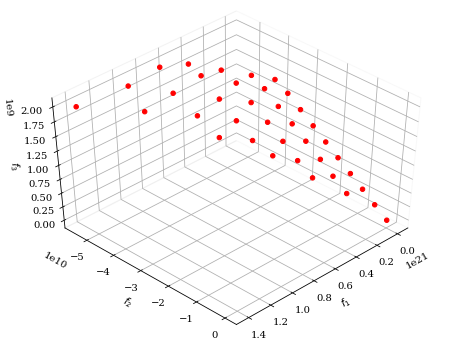

In [30]:
print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)
Scatter().add(res.F).show()
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

In [20]:
res.X[:,0]

array([12128.77750504, 12135.88873223, 12063.31464735, 12037.92594769,
       12148.35529209, 12049.49597086, 12006.76731097, 12010.30554094,
       12050.31720516, 12046.04139868, 12043.33734415, 12040.81540625,
       12622.63729604, 12148.96233862, 12622.63729604, 12055.52191674,
       12051.08496788, 12043.26341045, 12044.40980101, 12147.57658652,
       12048.70711119, 12130.40803398, 12046.04688574, 12055.25559672,
       12063.47943748, 12124.38304281, 12028.83264498, 12045.57946486,
       12050.57061139, 12011.40302233, 12125.45500406, 12125.48688101,
       12124.68740787, 12043.33487958, 12056.05736556, 12037.72491951,
       12010.06801834, 12124.38304281, 12036.50960258, 12033.04009995,
       12055.51442017, 12014.33448435, 12064.65064028, 12079.5920026 ,
       12055.51442017, 12049.50806887, 12050.99120399, 12123.84195458,
       12240.67940927, 12129.12183654, 12136.82771744, 12122.16364364,
       12624.20117865, 12040.49568591, 12012.72297857, 12051.80959873,
      

In [21]:
res.X[0,0]

12128.777505040658

In [22]:
demand_new=U_Demand-res.X[0,0]

In [23]:
demand_new

array([677.66862535])

In [ ]:
import plotly.graph_objects as go
import numpy as np


fig = go.Figure(data=[go.Scatter3d(x= res.F[:,0], y=res.F[:,1], z=res.F[:,2],
                                   mode='markers')])

fig.update_layout(scene = dict(
                    xaxis_title='first objective',
                    yaxis_title='second objective',
                    zaxis_title='third objective'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

class ZDT1(Problem):

    def __init__(self, n_var=30, n_obj=2, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, n_constr=0, xl=0, xu=1, type_var=anp.double, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = anp.linspace(0, 1, n_pareto_points)
        return anp.array([x, 1 - anp.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * anp.sum(x[:, 1:], axis=1)
        f2 = g * (1 - anp.power((f1 / g), 0.5))

        out["F"] = anp.column_stack([f1, f2])

# create the algorithm object
algorithm = NSGA3(pop_size=92,
                  ref_dirs=ref_dirs)
from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-6,
    f_tol=0.01,
    nth_gen=5,
    n_last=30,
    n_max_gen=1000,
    n_max_evals=100000
)
problem = ZDT1()

# execute the optimization
res = minimize(Problem,
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()

AttributeError: ignored

In [ ]:
import numpy as np
from pymoo.util.misc import stack
from pymoo.core.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[0]**2 + x[1]**2
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


elementwise_problem = MyProblem()

In [ ]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem


class ElementwiseSphereWithConstraint(ElementwiseProblem):

    def __init__(self):
        xl = np.zeros(10)
        xl[0] = -5.0

        xu = np.ones(10)
        xu[0] = 5.0

        super().__init__(n_var=10, n_obj=1, n_constr=2, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = np.sum((x - 0.5) ** 2)
        out["G"] = np.column_stack([0.1 - out["F"], out["F"] - 0.5])

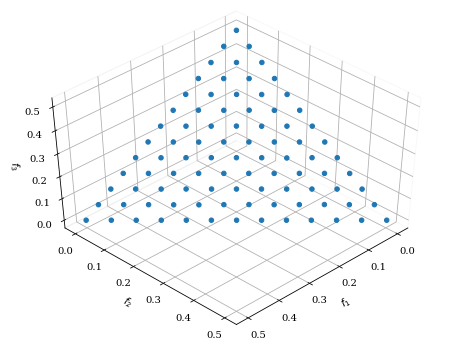

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_problem, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(pop_size=92,
                  ref_dirs=ref_dirs)

# execute the optimization
res = minimize(get_problem("dtlz1"),
               algorithm,
               seed=1,
               termination=('n_gen', 600))

Scatter().add(res.F).show()